# Explaining Regression Models

Most of the techniques used to explain classification models apply to regression as well. We will look at how to use the SHAP library to interpret regression models. 

We will interpret the XGBoost model for the Boston housing dataset:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


from sklearn.datasets import load_boston
from sklearn import model_selection, preprocessing, metrics

boston = load_boston()
X = pd.DataFrame(boston.data, columns=boston.feature_names)
y = boston.target

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=42)

import xgboost as xgb
xgr = xgb.XGBRegressor(random_state=42, base_score=0.5)
xgr.fit(X_train, y_train)

[14:02:45] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

## Shapley

Shapley is model agnostic. This library gives us global insight into our model and helps explain individual predictions.

We will first look at the preidction for index 5. Our model predicts the value to be 27.26:

In [2]:
sample_idx = 5
xgr.predict(X.iloc[[sample_idx]])

array([27.269186], dtype=float32)

To use the model, we have to create a `TreeExplainer` from our model and estimate the SHAP values for our samples.

In [4]:
import shap
shap.initjs()

In [5]:
exp = shap.TreeExplainer(xgr)
vals = exp.shap_values(X)

With the explainer and the SHAP values, we can create a force plot to explain the prediction. This informs us tha that the base prediction is 23, and that the population status (LSTAT) and property tax rate (TAX) push the price up, while the number of rooms (RM) pushes the price down:

In [6]:
shap.force_plot(exp.expected_value, vals[sample_idx],
                X.iloc[sample_idx])

We can view the force plot for all of the samples as well to get an overall feel of the behavior.

In [7]:
shap.force_plot(exp.expected_value, vals, X)

From the force plot of the sample, we saw that the LSAT feature has a big impact. To visualize how LSTAT affects the result, we can create a dependence plot.

From the dependence plot for LSTAT, we can see that LSTAT increases (the percent of lower status population), the SHAP value goes down (pushing down the target). A very lower LSTAT value pushes SHAP up. From viewing the coloring of the TAX (property tax rate), it appears taht as the rate goes down (more blue), the SHAP value goes up:

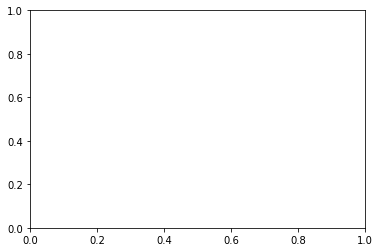

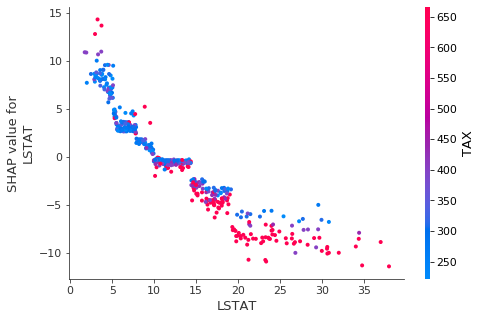

In [9]:
fig, ax = plt.subplots(figsize=(6,4))
shap.dependence_plot("LSTAT", vals, X)

Here is another dependence plot to explore the DIS (distance to employment centers). It appears that this feature has little effect unles it is very small:

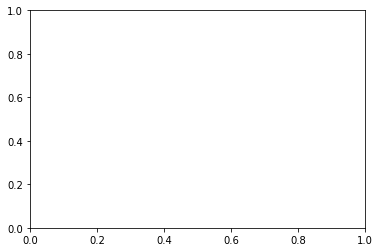

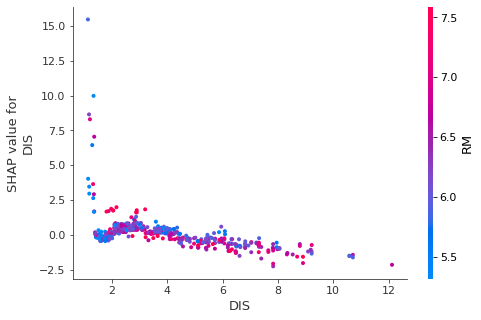

In [12]:
fig, ax = plt.subplots(figsize=(6,4))
shap.dependence_plot("DIS", vals, X, interaction_index="RM")

Finally, we will look at the global effect of the features using a summary plot. The features at the top have the most impact to the model. From this view you can see that large values of RM (number of rooms) push up the target, while medium and small values push it down:

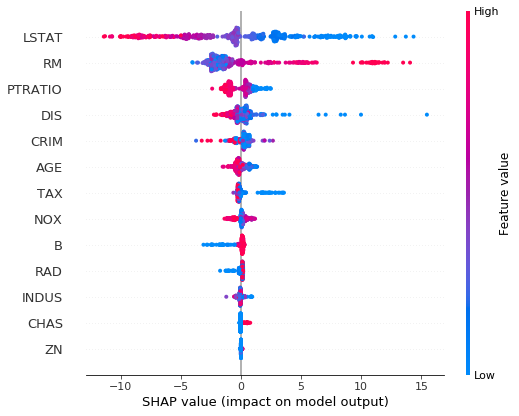

In [13]:
fig, ax = plt.subplots(figsize=(6,4))
shap.summary_plot(vals, X)